In [68]:
# Packages
import numpy as np
import h5py
from PIL import Image
import zipfile
import matplotlib.pyplot as plt

In [126]:
# Activation functions

def sigmoid(z):
    s = 1/(1 + np.exp(-z))
    return s,z

def sigmoid_backward(dA,activation_cache):
    Z = activation_cache
    sigmoid_Z, _ = sigmoid(Z)
    dZ = dA * sigmoid_Z * (1 - sigmoid_Z)  # Chain rule --> dZ = dL/dZ = (dL/dA)*(dA/dZ) = dA * (dA/dZ) --> dA/dZ = 1 if (Z>0) or 0 if (Z<0)
    return dZ

def relu(z):
    s = np.maximum(z,0)
    return s,z

def relu_backward(dA,activation_cache):
    Z = activation_cache
    dZ = dA * (Z>0)     # Chain rule --> dZ = dL/dZ = (dL/dA)*(dA/dZ) = dA * (dA/dZ) --> dA/dZ = 1 if (Z>0) or 0 if (Z<0)
    return dZ

In [70]:
# He initialization
def initialize_parameters(layer_dims):
    L = len(layer_dims)
    parameters = {}

    for l in range (1,L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2./layers_dims[l-1])  # He initialization
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))

    return parameters

In [71]:
def linear_forward(A,W,b):
    Z = np.dot(W,A) + b
    cache = (A,W,b)

    return Z,cache

In [72]:
def linear_activation_forward(A_prev,W,b,activation):

    if activation == "sigmoid":
       Z,linear_cache = linear_forward(A_prev,W,b)
       A,activation_cache = sigmoid(Z)
    elif activation == "relu":
       Z,linear_cache = linear_forward(A_prev,W,b)
       A,activation_cache = relu(Z)

    cache = (linear_cache,activation_cache)  # ==> (A_prev,W,b,Z)
    return A,cache

In [73]:
def L_model_forward(X,parameters):
    caches = []
    A = X
    L = len(parameters)//2

    for l in range(1,L):
        A_prev = A
        A,cache = linear_activation_forward(A_prev,parameters['W' + str(l)],parameters['b' + str(l)],activation = "relu")
        caches.append(cache)

    AL,cache = linear_activation_forward(A_prev,parameters['W' + str(L)],parameters['b' + str(L)],activation = "sigmoid")
    caches.append(cache)

    return AL,caches

In [74]:
def compute_cost(AL,Y):
    m = Y.shape[0]

    cost = (-1.0/m)*(np.dot(Y,np.log(AL).T) + np.dot((1-Y),np.log(1-AL).T))

    cost = np.squeeze(cost)
    return cost

In [75]:
def linear_backward(dZ,cache):
    A_prev,W,b = cache
    m = A_prev.shape[1]   # no. of columns

    dW = (1.0/m)*np.dot(dZ,A_prev.T)
    db = (1.0/m)*(np.sum(dZ,axis = 1,keepdims = True))
    dA_prev = np.dot(W.T,dZ)

    return dA_prev,dW,db

In [76]:
def linear_activation_backward(dA,cache,activation):
    linear_cache, activation_cache = cache

    if activation == "sigmoid":
       dZ = sigmoid_backward(dA,activation_cache)
       dA_prev,dW,db = linear_backward(dZ,linear_cache)
    elif activation == "relu":
       dZ = relu_backward(dA,activation_cache)
       dA_prev,dW,db = linear_backward(dZ,linear_cache)

    return dA_prev,dW,db

In [77]:
def L_model_backward(AL,Y,caches):
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    grads = {}

    dAL = - np.divide(Y,AL) + np.divide(1-Y,1-AL)

    # Backprop for sigmoid function in the last layer
    current_cache = caches[L-1]
    dA_prev_temp,dW_temp,db_temp = linear_activation_backward(dAL,current_cache,activation = "sigmoid")
    grads['dA'+str(L-1)] = dA_prev_temp
    grads['dW'+str(L)] = dW_temp
    grads['db'+str(L)] = db_temp

    # Now for ReLU which is from L-2 to 0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp,dW_temp,db_temp = linear_activation_backward(grads['dA'+str(l+1)],current_cache,activation = "relu")
        grads['dA'+str(l)] = dA_prev_temp
        grads['dW'+str(l+1)] = dW_temp
        grads['db'+str(l+1)] = db_temp

    return grads

In [127]:
def update_parameters(parameters,grads,learning_rate):
    L = len(parameters)//2

    for l in range (1,L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * grads['db'+str(l)]

    return parameters

In [128]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [129]:
!kaggle datasets download -d muhammeddalkran/catvnoncat

catvnoncat.zip: Skipping, found more recently modified local copy (use --force to force download)


In [130]:
zip_ref = zipfile.ZipFile('/content/catvnoncat.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [131]:
# IMPORTANT ***
test = h5py.File('/content/catvnoncat/test_catvnoncat.h5', 'r')
test_x_orig = test['test_set_x']
test_y = test['test_set_y']
train = h5py.File('/content/catvnoncat/train_catvnoncat.h5', 'r')
train_x_orig = train['train_set_x']
train_y = train['train_set_y']

classes = ["cat","non-cat"]


In [132]:
train_x_orig = np.array(train_x_orig)
test_x_orig = np.array(test_x_orig)

train_x = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x / 255
test_x = test_x / 255


In [133]:
layers_dims = [train_x.shape[0], 64, 256, 16, 16, 1]

In [134]:
def L_layer_model(X,Y,layer_dims,learning_rate=0.0075,num_iterations=300):
  costs = []
  parameters = initialize_parameters(layer_dims)

  for i in range(0,num_iterations):
    AL,caches = L_model_forward(X,parameters)
    cost = compute_cost(AL,Y)
    grads = L_model_backward(AL,Y,caches)
    parameters = update_parameters(parameters,grads,learning_rate)

    if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

  return parameters, costs

In [135]:
from sklearn.metrics import accuracy_score
train_x = np.array(train_x)
train_y = np.array(train_y)
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations=1000)

def predict(X, parameters):
    AL, _ = L_model_forward(X, parameters)
    predictions = (AL > 0.5).astype(int)
    return predictions

test_predictions = predict(test_x, parameters)
test_predictions = test_predictions.reshape(test_y.shape)

test_accuracy = accuracy_score(test_y, test_predictions)
print("Test Accuracy: {:.2%}".format(test_accuracy))


Test Accuracy: 76.00%


It is a "cat" picture.


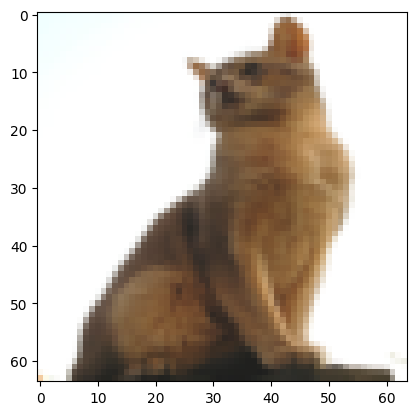

In [150]:
Y_prediction_test, _ = L_model_forward(test_x, parameters)

index = 6

plt.imshow(test_x[:, index].reshape((64, 64, 3)))
print("It is a \"" + classes[int(Y_prediction_test[0,index])] + "\" picture.")